# ResNet Ablation Study

Ablation Study, 직역하자면 '제거 연구'를 진행합니다. 

딥러닝 논문에서 여러가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시합니다. 이 제한한 방법들이 유효함을 증명하기 위해서 보통 딥러닝 논문에서 해당 방법을 '제거'한 모델로 수행한 실험과 해당방법을 추가한 모델로 수행한 실험의 결과를 비교합니다. 

Ablation study란 이처럼 아이디어를 제거해봄으로써 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험입니다. 

## (0) 라이브러리 버전 확인하기
---

In [1]:
import tensorflow as tf
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
print(tf.__version__)
print(np.__version__)



2.6.0
1.21.4


## (1) ResNet 기본블록 구성하기
---

ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해보고 진행합니다.


최근 나오는 일반적인 딥러닝 모델에서 주요구조를 모듈화시켜 조금씩 바꾸어 쓸 수 있는 단위를 Block이라고 합니다. layer는 기본적으로 텐서플로, 케라스, 파이토치 등에서 기본적으로 제공하는 단위입니다. 여기서 한단계 위인 block을 단위로 모델을 만들어볼 것입니다. 

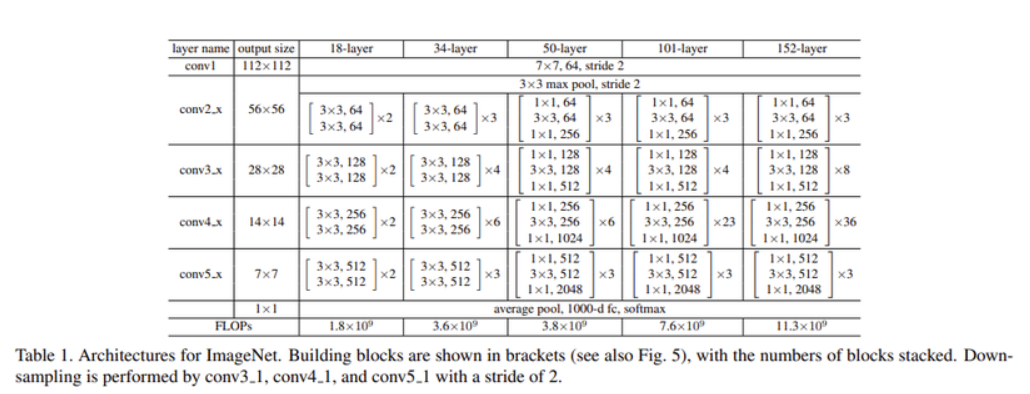

ResNet-34와 ResNet-50은 모두 conv block 블록구조를 각각 3, 4, 6, 3개씩 반복하여 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다. 

블록을 생성하는 함수를 만듭니다. 

### Conv Block

In [2]:
def conv_batch(layer,
               channel, 
               kernel_size, 
               padding='same', 
               strides=1,
               activation='relu',
               name='0'):
    x = keras.layers.Conv2D(filters=channel,
                          kernel_size=kernel_size,
                          kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          padding=padding,
                          strides=strides,
                          name=f'conv_{name}')(layer)
    x = keras.layers.Activation(activation, name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
        
    return x
    

### Plain block

In [3]:


def build_plain_block(input_layer,
                      block_num=0,
                      num_cnn=3, 
                      channel=64,
                      is_50=True,
                   ):
    # 입력 레이어
    x = input_layer

    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel,(1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
                
                
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                
    return x


## (2) 일반 네트워크(Plain Network) 만들기
---
ResNet의 핵심 아이디어인 skip connection 및 residual network가 없는 plain network를 만들어줍니다. 

### Build Plain Network

In [4]:
def build_plain(num_cnn_list, channel_list, 
                is_50=True, cats_vs_dogs=False, 
                input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    assert len(num_cnn_list) == len(channel_list) # 가정 설정문
    
    input_layer = keras.layers.Input(shape=input_shape, name='input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid', 
                                    kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal', name='FC')(gap)
        
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model
    
    

### Plain-34

In [5]:
plain_34 = build_plain(num_cnn_list=[3,4,6,3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')

plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (Activation)     (None, 112, 112, 64)      0         
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_0_01 (Activation)      (None, 56, 56, 64)        0  

### Plain-50

In [6]:
plain_50 = build_plain(num_cnn_list = [3,4,6,3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))

plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (Activation)     (None, 112, 112, 64)      0         
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_0_01 (Activation)      (None, 56, 56, 64)        0  

## (3) ResNet 34, ResNet 50 Complete Model
---

### ResNet
---
### Residual block

In [7]:
def build_residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

### Build ResNet

In [8]:
def build_resnet(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

### ResNet 34

In [9]:
resnet_34 = build_resnet(num_cnn_list=[3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34'
                        )
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (Activation)        (None, 112, 112, 64) 0           conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

### ResNet 50

In [10]:
resnet_50 = build_resnet(num_cnn_list = [3,4,6,3],
                         channel_list = [64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))

resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (Activation)        (None, 112, 112, 64) 0           conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

## (4)  Ablation Study
---
* ResNet-34 vs Plain-34
* ResNet-50 vs Plain-50


tensorflow-datasets 에서 제공하는 cats_vs_dogs 데이터셋을 사용합니다. 


In [11]:
# dataset load

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

In [12]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [14]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224,224])
    return tf.cast(image, tf.float32) / 255. , label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
        

In [15]:
BATCH_SIZE = 32
EPOCH = 20

In [16]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [17]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(lr)
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(lr)
    return lr

In [18]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)
# lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [19]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3),
                         name='ResNet_34')

In [20]:

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/654 [>.............................] - ETA: 1:36 - loss: 50.4406 - accuracy: 0.5022

 40/654 [>.............................] - ETA: 1:34 - loss: 36.0319 - accuracy: 0.4898

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/654 [====>.........................] - ETA: 1:23 - loss: 14.2859 - accuracy: 0.4931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/654 [=============>................] - ETA: 51s - loss: 6.5182 - accuracy: 0.4973

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/654 [==============>...............] - ETA: 49s - loss: 6.3500 - accuracy: 0.4964

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/654 [==============>...............] - ETA: 48s - loss: 6.2291 - accuracy: 0.4958

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/654 [===============>..............] - ETA: 43s - loss: 5.9340 - accuracy: 0.4991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/654 [================>.............] - ETA: 43s - loss: 5.8743 - accuracy: 0.4991

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/654 [=========================>....] - ETA: 11s - loss: 4.5629 - accuracy: 0.4981

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


609/654 [==========================>...] - ETA: 6s - loss: 4.4354 - accuracy: 0.4980

621/654 [===========================>..] - ETA: 5s - loss: 4.3891 - accuracy: 0.4980

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 4.2701 - accuracy: 0.4983

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 129s 173ms/step - loss: 4.2701 - accuracy: 0.4983 - val_loss: 2.0206 - val_accuracy: 0.4991
Epoch 2/20
 40/654 [>.............................] - ETA: 1:50 - loss: 2.0098 - accuracy: 0.5166

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


249/654 [==========>...................] - ETA: 1:04 - loss: 1.9586 - accuracy: 0.5013

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


260/654 [==========>...................] - ETA: 1:02 - loss: 1.9558 - accuracy: 0.5023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


273/654 [===========>..................] - ETA: 1:00 - loss: 1.9526 - accuracy: 0.5030

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


300/654 [============>.................] - ETA: 56s - loss: 1.9458 - accuracy: 0.5038

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


306/654 [=============>................] - ETA: 55s - loss: 1.9443 - accuracy: 0.5046

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


506/654 [======================>.......] - ETA: 23s - loss: 1.8965 - accuracy: 0.5055

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


539/654 [=======================>......] - ETA: 17s - loss: 1.8888 - accuracy: 0.5052

548/654 [========================>.....] - ETA: 16s - loss: 1.8867 - accuracy: 0.5046

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


624/654 [===========================>..] - ETA: 4s - loss: 1.8694 - accuracy: 0.5049

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.8627 - accuracy: 0.5053

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 111s 170ms/step - loss: 1.8627 - accuracy: 0.5053 - val_loss: 1.7197 - val_accuracy: 0.4983
Epoch 3/20
175/654 [=======>......................] - ETA: 1:13 - loss: 1.6820 - accuracy: 0.4913

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


187/654 [=======>......................] - ETA: 1:12 - loss: 1.6796 - accuracy: 0.4930

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


200/654 [========>.....................] - ETA: 1:10 - loss: 1.6774 - accuracy: 0.4909

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


227/654 [=========>....................] - ETA: 1:05 - loss: 1.6721 - accuracy: 0.4905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/654 [=========>....................] - ETA: 1:04 - loss: 1.6709 - accuracy: 0.4895

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


436/654 [===================>..........] - ETA: 33s - loss: 1.6325 - accuracy: 0.4915

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


465/654 [====================>.........] - ETA: 28s - loss: 1.6272 - accuracy: 0.4900

476/654 [====================>.........] - ETA: 27s - loss: 1.6253 - accuracy: 0.4905

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


551/654 [========================>.....] - ETA: 15s - loss: 1.6119 - accuracy: 0.4910

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.5939 - accuracy: 0.4901

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 1.5939 - accuracy: 0.4901 - val_loss: 1.4814 - val_accuracy: 0.5030
Epoch 4/20
102/654 [===>..........................] - ETA: 1:24 - loss: 1.4646 - accuracy: 0.5034

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


115/654 [====>.........................] - ETA: 1:22 - loss: 1.4623 - accuracy: 0.5068

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


127/654 [====>.........................] - ETA: 1:20 - loss: 1.4608 - accuracy: 0.5054

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


154/654 [======>.......................] - ETA: 1:16 - loss: 1.4572 - accuracy: 0.5067

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


160/654 [======>.......................] - ETA: 1:15 - loss: 1.4562 - accuracy: 0.5066

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/654 [===============>..............] - ETA: 44s - loss: 1.4268 - accuracy: 0.5036

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


395/654 [=================>............] - ETA: 39s - loss: 1.4218 - accuracy: 0.5059

406/654 [=================>............] - ETA: 38s - loss: 1.4203 - accuracy: 0.5061

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


479/654 [====================>.........] - ETA: 26s - loss: 1.4103 - accuracy: 0.5052

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.3865 - accuracy: 0.5039

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 110s 168ms/step - loss: 1.3865 - accuracy: 0.5039 - val_loss: 1.2969 - val_accuracy: 0.5200
Epoch 5/20
 31/654 [>.............................] - ETA: 1:35 - loss: 1.2950 - accuracy: 0.5030

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 45/654 [=>............................] - ETA: 1:32 - loss: 1.2944 - accuracy: 0.5021

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 55/654 [=>............................] - ETA: 1:31 - loss: 1.2932 - accuracy: 0.4915

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/654 [==>...........................] - ETA: 1:27 - loss: 1.2902 - accuracy: 0.4893

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 88/654 [===>..........................] - ETA: 1:26 - loss: 1.2893 - accuracy: 0.4915

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


289/654 [============>.................] - ETA: 56s - loss: 1.2660 - accuracy: 0.5018

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


323/654 [=============>................] - ETA: 50s - loss: 1.2621 - accuracy: 0.5021

333/654 [==============>...............] - ETA: 49s - loss: 1.2610 - accuracy: 0.5023

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


408/654 [=================>............] - ETA: 37s - loss: 1.2525 - accuracy: 0.5039

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


613/654 [===========================>..] - ETA: 6s - loss: 1.2317 - accuracy: 0.5032

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


626/654 [===========================>..] - ETA: 4s - loss: 1.2304 - accuracy: 0.5033

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


638/654 [============================>.] - ETA: 2s - loss: 1.2291 - accuracy: 0.5035

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.2275 - accuracy: 0.5042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 110s 168ms/step - loss: 1.2275 - accuracy: 0.5042 - val_loss: 1.1645 - val_accuracy: 0.4790
Epoch 6/20
 11/654 [..............................] - ETA: 1:37 - loss: 1.1568 - accuracy: 0.5455

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 17/654 [..............................] - ETA: 1:36 - loss: 1.1567 - accuracy: 0.5276

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/654 [=========>....................] - ETA: 1:06 - loss: 1.1398 - accuracy: 0.5099

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


251/654 [==========>...................] - ETA: 1:01 - loss: 1.1374 - accuracy: 0.5075

262/654 [===========>..................] - ETA: 1:00 - loss: 1.1366 - accuracy: 0.5066

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


335/654 [==============>...............] - ETA: 48s - loss: 1.1302 - accuracy: 0.5039

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


542/654 [=======================>......] - ETA: 17s - loss: 1.1131 - accuracy: 0.5003

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


555/654 [========================>.....] - ETA: 15s - loss: 1.1120 - accuracy: 0.5004

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


565/654 [========================>.....] - ETA: 13s - loss: 1.1113 - accuracy: 0.5005

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


592/654 [==========================>...] - ETA: 9s - loss: 1.1092 - accuracy: 0.5007

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


598/654 [==========================>...] - ETA: 8s - loss: 1.1086 - accuracy: 0.5012

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.1043 - accuracy: 0.5013

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 1.1043 - accuracy: 0.5013 - val_loss: 1.0519 - val_accuracy: 0.4974
Epoch 7/20
147/654 [=====>........................] - ETA: 1:17 - loss: 1.0429 - accuracy: 0.4970

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/654 [=======>......................] - ETA: 1:13 - loss: 1.0411 - accuracy: 0.4958

187/654 [=======>......................] - ETA: 1:11 - loss: 1.0402 - accuracy: 0.4977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/654 [===========>..................] - ETA: 1:00 - loss: 1.0359 - accuracy: 0.4926

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


471/654 [====================>.........] - ETA: 28s - loss: 1.0218 - accuracy: 0.4950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


480/654 [=====================>........] - ETA: 26s - loss: 1.0212 - accuracy: 0.4956

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


493/654 [=====================>........] - ETA: 24s - loss: 1.0204 - accuracy: 0.4956

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


520/654 [======================>.......] - ETA: 20s - loss: 1.0187 - accuracy: 0.4963

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


526/654 [=======================>......] - ETA: 19s - loss: 1.0182 - accuracy: 0.4971

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.0103 - accuracy: 0.4988

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 1.0103 - accuracy: 0.4988 - val_loss: 0.9692 - val_accuracy: 0.5022
Epoch 8/20
 75/654 [==>...........................] - ETA: 1:28 - loss: 0.9656 - accuracy: 0.5017

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


105/654 [===>..........................] - ETA: 1:24 - loss: 0.9646 - accuracy: 0.4964

118/654 [====>.........................] - ETA: 1:22 - loss: 0.9636 - accuracy: 0.4992

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


190/654 [=======>......................] - ETA: 1:11 - loss: 0.9599 - accuracy: 0.4928

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


396/654 [=================>............] - ETA: 39s - loss: 0.9499 - accuracy: 0.4969

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


410/654 [=================>............] - ETA: 37s - loss: 0.9491 - accuracy: 0.4975

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


423/654 [==================>...........] - ETA: 35s - loss: 0.9484 - accuracy: 0.4984

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


450/654 [===================>..........] - ETA: 31s - loss: 0.9473 - accuracy: 0.4994

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


456/654 [===================>..........] - ETA: 30s - loss: 0.9471 - accuracy: 0.4990

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.9379 - accuracy: 0.4989

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.9379 - accuracy: 0.4989 - val_loss: 0.9050 - val_accuracy: 0.5152
Epoch 9/20
  4/654 [..............................] - ETA: 1:38 - loss: 0.9051 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/654 [>.............................] - ETA: 1:34 - loss: 0.9041 - accuracy: 0.5000

 43/654 [>.............................] - ETA: 1:33 - loss: 0.9033 - accuracy: 0.5102

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/654 [====>.........................] - ETA: 1:21 - loss: 0.9003 - accuracy: 0.5068

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/654 [==============>...............] - ETA: 50s - loss: 0.8930 - accuracy: 0.5010

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/654 [==============>...............] - ETA: 48s - loss: 0.8926 - accuracy: 0.5020

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/654 [===============>..............] - ETA: 46s - loss: 0.8921 - accuracy: 0.5028

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/654 [================>.............] - ETA: 42s - loss: 0.8910 - accuracy: 0.5019

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/654 [================>.............] - ETA: 41s - loss: 0.8908 - accuracy: 0.5016

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


585/654 [=========================>....] - ETA: 10s - loss: 0.8833 - accuracy: 0.5005

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


615/654 [===========================>..] - ETA: 5s - loss: 0.8823 - accuracy: 0.4990

628/654 [===========================>..] - ETA: 3s - loss: 0.8818 - accuracy: 0.4996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8809 - accuracy: 0.5001

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.8809 - accuracy: 0.5001 - val_loss: 0.8563 - val_accuracy: 0.4947
Epoch 10/20
 47/654 [=>............................] - ETA: 1:32 - loss: 0.8573 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


252/654 [==========>...................] - ETA: 1:01 - loss: 0.8504 - accuracy: 0.5020

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


266/654 [===========>..................] - ETA: 59s - loss: 0.8499 - accuracy: 0.5026

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


279/654 [===========>..................] - ETA: 57s - loss: 0.8494 - accuracy: 0.5026

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


306/654 [=============>................] - ETA: 53s - loss: 0.8485 - accuracy: 0.5027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


312/654 [=============>................] - ETA: 52s - loss: 0.8484 - accuracy: 0.5022

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


513/654 [======================>.......] - ETA: 21s - loss: 0.8424 - accuracy: 0.4978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


545/654 [========================>.....] - ETA: 16s - loss: 0.8416 - accuracy: 0.4969

554/654 [========================>.....] - ETA: 15s - loss: 0.8414 - accuracy: 0.4964

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


629/654 [===========================>..] - ETA: 3s - loss: 0.8393 - accuracy: 0.4960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8387 - accuracy: 0.4961

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.8387 - accuracy: 0.4961 - val_loss: 0.8237 - val_accuracy: 0.4861
Epoch 11/20
180/654 [=======>......................] - ETA: 1:12 - loss: 0.8157 - accuracy: 0.4970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


193/654 [=======>......................] - ETA: 1:10 - loss: 0.8154 - accuracy: 0.4972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


205/654 [========>.....................] - ETA: 1:09 - loss: 0.8154 - accuracy: 0.4960

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


232/654 [=========>....................] - ETA: 1:04 - loss: 0.8146 - accuracy: 0.4981

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


238/654 [=========>....................] - ETA: 1:03 - loss: 0.8145 - accuracy: 0.4976

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


440/654 [===================>..........] - ETA: 32s - loss: 0.8093 - accuracy: 0.5019

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


473/654 [====================>.........] - ETA: 27s - loss: 0.8086 - accuracy: 0.5015

481/654 [=====================>........] - ETA: 26s - loss: 0.8082 - accuracy: 0.5028

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


558/654 [========================>.....] - ETA: 14s - loss: 0.8071 - accuracy: 0.5005

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.8051 - accuracy: 0.5004 - val_loss: 0.7929 - val_accuracy: 0.4818
Epoch 12/20
111/654 [====>.........................] - ETA: 1:23 - loss: 0.7896 - accuracy: 0.5051

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


120/654 [====>.........................] - ETA: 1:21 - loss: 0.7893 - accuracy: 0.5065

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


134/654 [=====>........................] - ETA: 1:19 - loss: 0.7889 - accuracy: 0.5054

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


161/654 [======>.......................] - ETA: 1:15 - loss: 0.7884 - accuracy: 0.5052

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


167/654 [======>.......................] - ETA: 1:14 - loss: 0.7880 - accuracy: 0.5071

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


369/654 [===============>..............] - ETA: 43s - loss: 0.7846 - accuracy: 0.4993

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


400/654 [=================>............] - ETA: 38s - loss: 0.7842 - accuracy: 0.4998

412/654 [=================>............] - ETA: 37s - loss: 0.7840 - accuracy: 0.4989

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


483/654 [=====================>........] - ETA: 26s - loss: 0.7827 - accuracy: 0.4968

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7797 - accuracy: 0.4989

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7797 - accuracy: 0.4989 - val_loss: 0.7672 - val_accuracy: 0.5123
Epoch 13/20
 38/654 [>.............................] - ETA: 1:33 - loss: 0.7678 - accuracy: 0.4918

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 51/654 [=>............................] - ETA: 1:32 - loss: 0.7674 - accuracy: 0.5018

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/654 [=>............................] - ETA: 1:30 - loss: 0.7674 - accuracy: 0.5036

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/654 [===>..........................] - ETA: 1:26 - loss: 0.7668 - accuracy: 0.5018

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 94/654 [===>..........................] - ETA: 1:25 - loss: 0.7670 - accuracy: 0.5017

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


296/654 [============>.................] - ETA: 54s - loss: 0.7651 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


328/654 [==============>...............] - ETA: 50s - loss: 0.7648 - accuracy: 0.5004

340/654 [==============>...............] - ETA: 48s - loss: 0.7646 - accuracy: 0.5017

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


412/654 [=================>............] - ETA: 37s - loss: 0.7635 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


620/654 [===========================>..] - ETA: 5s - loss: 0.7609 - accuracy: 0.5025

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


632/654 [===========================>..] - ETA: 3s - loss: 0.7608 - accuracy: 0.5016

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


643/654 [============================>.] - ETA: 1s - loss: 0.7607 - accuracy: 0.5011

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7605 - accuracy: 0.5006 - val_loss: 0.7507 - val_accuracy: 0.4909
Epoch 14/20
 17/654 [..............................] - ETA: 1:36 - loss: 0.7506 - accuracy: 0.5110

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 23/654 [>.............................] - ETA: 1:35 - loss: 0.7489 - accuracy: 0.5231

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


225/654 [=========>....................] - ETA: 1:05 - loss: 0.7491 - accuracy: 0.5033

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/654 [==========>...................] - ETA: 1:00 - loss: 0.7486 - accuracy: 0.5055

267/654 [===========>..................] - ETA: 59s - loss: 0.7485 - accuracy: 0.5055

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


342/654 [==============>...............] - ETA: 47s - loss: 0.7477 - accuracy: 0.5058

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


546/654 [========================>.....] - ETA: 16s - loss: 0.7455 - accuracy: 0.5041

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


560/654 [========================>.....] - ETA: 14s - loss: 0.7454 - accuracy: 0.5028

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


571/654 [=========================>....] - ETA: 12s - loss: 0.7453 - accuracy: 0.5026

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


598/654 [==========================>...] - ETA: 8s - loss: 0.7451 - accuracy: 0.5035

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


604/654 [==========================>...] - ETA: 7s - loss: 0.7450 - accuracy: 0.5032

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.5032

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7447 - accuracy: 0.5032 - val_loss: 0.7368 - val_accuracy: 0.5136
Epoch 15/20
152/654 [=====>........................] - ETA: 1:17 - loss: 0.7366 - accuracy: 0.5006

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


184/654 [=======>......................] - ETA: 1:12 - loss: 0.7364 - accuracy: 0.5019

196/654 [=======>......................] - ETA: 1:10 - loss: 0.7363 - accuracy: 0.4998

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/654 [===========>..................] - ETA: 59s - loss: 0.7358 - accuracy: 0.5007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


475/654 [====================>.........] - ETA: 27s - loss: 0.7347 - accuracy: 0.5028

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


489/654 [=====================>........] - ETA: 25s - loss: 0.7346 - accuracy: 0.5023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


499/654 [=====================>........] - ETA: 23s - loss: 0.7345 - accuracy: 0.5026

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


527/654 [=======================>......] - ETA: 19s - loss: 0.7343 - accuracy: 0.5027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


533/654 [=======================>......] - ETA: 18s - loss: 0.7342 - accuracy: 0.5030

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.5029

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7332 - accuracy: 0.5029 - val_loss: 0.7318 - val_accuracy: 0.4781
Epoch 16/20
 79/654 [==>...........................] - ETA: 1:27 - loss: 0.7270 - accuracy: 0.5051

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


111/654 [====>.........................] - ETA: 1:23 - loss: 0.7275 - accuracy: 0.4890

123/654 [====>.........................] - ETA: 1:21 - loss: 0.7282 - accuracy: 0.4901

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


198/654 [========>.....................] - ETA: 1:10 - loss: 0.7282 - accuracy: 0.4893

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


405/654 [=================>............] - ETA: 38s - loss: 0.7265 - accuracy: 0.4908

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


415/654 [==================>...........] - ETA: 36s - loss: 0.7264 - accuracy: 0.4907

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


427/654 [==================>...........] - ETA: 34s - loss: 0.7263 - accuracy: 0.4914

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


454/654 [===================>..........] - ETA: 30s - loss: 0.7260 - accuracy: 0.4934

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


460/654 [====================>.........] - ETA: 29s - loss: 0.7260 - accuracy: 0.4929

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.4969

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7247 - accuracy: 0.4969 - val_loss: 0.7194 - val_accuracy: 0.4957
Epoch 17/20
  9/654 [..............................] - ETA: 1:38 - loss: 0.7189 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 42/654 [>.............................] - ETA: 1:33 - loss: 0.7202 - accuracy: 0.4859

 51/654 [=>............................] - ETA: 1:32 - loss: 0.7200 - accuracy: 0.4902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/654 [====>.........................] - ETA: 1:21 - loss: 0.7199 - accuracy: 0.4995

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/654 [==============>...............] - ETA: 49s - loss: 0.7188 - accuracy: 0.5012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/654 [==============>...............] - ETA: 47s - loss: 0.7187 - accuracy: 0.5015

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/654 [===============>..............] - ETA: 45s - loss: 0.7186 - accuracy: 0.5014

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/654 [================>.............] - ETA: 41s - loss: 0.7186 - accuracy: 0.5011

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/654 [================>.............] - ETA: 40s - loss: 0.7186 - accuracy: 0.5011

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


592/654 [==========================>...] - ETA: 9s - loss: 0.7180 - accuracy: 0.5004

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


623/654 [===========================>..] - ETA: 4s - loss: 0.7179 - accuracy: 0.5004

632/654 [===========================>..] - ETA: 3s - loss: 0.7178 - accuracy: 0.4997

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.4998

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7177 - accuracy: 0.4998 - val_loss: 0.7156 - val_accuracy: 0.5117
Epoch 18/20
 52/654 [=>............................] - ETA: 1:31 - loss: 0.7162 - accuracy: 0.4988

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


259/654 [==========>...................] - ETA: 1:00 - loss: 0.7146 - accuracy: 0.4952

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


271/654 [===========>..................] - ETA: 58s - loss: 0.7146 - accuracy: 0.4942

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


284/654 [============>.................] - ETA: 56s - loss: 0.7144 - accuracy: 0.4965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


311/654 [=============>................] - ETA: 52s - loss: 0.7141 - accuracy: 0.4980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


317/654 [=============>................] - ETA: 51s - loss: 0.7141 - accuracy: 0.4977

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


518/654 [======================>.......] - ETA: 20s - loss: 0.7137 - accuracy: 0.4982

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


551/654 [========================>.....] - ETA: 15s - loss: 0.7136 - accuracy: 0.4977

561/654 [========================>.....] - ETA: 14s - loss: 0.7135 - accuracy: 0.4980

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


636/654 [============================>.] - ETA: 2s - loss: 0.7139 - accuracy: 0.4994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.4995

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7137 - accuracy: 0.4995 - val_loss: 0.7116 - val_accuracy: 0.5000
Epoch 19/20
187/654 [=======>......................] - ETA: 1:11 - loss: 0.7099 - accuracy: 0.4973

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


200/654 [========>.....................] - ETA: 1:09 - loss: 0.7102 - accuracy: 0.4938

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


211/654 [========>.....................] - ETA: 1:07 - loss: 0.7100 - accuracy: 0.4947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


239/654 [=========>....................] - ETA: 1:03 - loss: 0.7099 - accuracy: 0.4925

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


245/654 [==========>...................] - ETA: 1:02 - loss: 0.7098 - accuracy: 0.4921

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


448/654 [===================>..........] - ETA: 31s - loss: 0.7092 - accuracy: 0.4953

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


480/654 [=====================>........] - ETA: 26s - loss: 0.7089 - accuracy: 0.4982

487/654 [=====================>........] - ETA: 25s - loss: 0.7089 - accuracy: 0.4978

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


562/654 [========================>.....] - ETA: 14s - loss: 0.7089 - accuracy: 0.4970

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.4983

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7086 - accuracy: 0.4983 - val_loss: 0.7080 - val_accuracy: 0.4764
Epoch 20/20
116/654 [====>.........................] - ETA: 1:22 - loss: 0.7082 - accuracy: 0.4976

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/654 [====>.........................] - ETA: 1:20 - loss: 0.7082 - accuracy: 0.5002

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


139/654 [=====>........................] - ETA: 1:18 - loss: 0.7082 - accuracy: 0.4991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


167/654 [======>.......................] - ETA: 1:14 - loss: 0.7081 - accuracy: 0.4938

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


173/654 [======>.......................] - ETA: 1:13 - loss: 0.7080 - accuracy: 0.4926

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


376/654 [================>.............] - ETA: 42s - loss: 0.7070 - accuracy: 0.4864

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


406/654 [=================>............] - ETA: 37s - loss: 0.7067 - accuracy: 0.4879

416/654 [==================>...........] - ETA: 36s - loss: 0.7067 - accuracy: 0.4879

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


491/654 [=====================>........] - ETA: 24s - loss: 0.7063 - accuracy: 0.4915

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.4950

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 167ms/step - loss: 0.7060 - accuracy: 0.4950 - val_loss: 0.7022 - val_accuracy: 0.5056


In [21]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list = [64, 128, 256, 512],
                         is_50=True,
                         cats_vs_dogs=True,
                        input_shape=(224,224,3))

In [22]:
resnet_50.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
                  metrics=['accuracy']
                 )

history_50 = resnet_50.fit(ds_train,
                           steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
                           validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
                           epochs=EPOCH,
                           validation_data=ds_test,
                           verbose=1,
                           callbacks=[lr_scheduler],
                           use_multiprocessing=True
                          )

Epoch 1/20


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/654 [>.............................] - ETA: 1:03 - loss: 18.8931 - accuracy: 0.4823

 38/654 [>.............................] - ETA: 1:03 - loss: 16.1752 - accuracy: 0.4836

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/654 [====>.........................] - ETA: 55s - loss: 9.3173 - accuracy: 0.4951

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/654 [=============>................] - ETA: 34s - loss: 6.9203 - accuracy: 0.5057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/654 [==============>...............] - ETA: 33s - loss: 6.8741 - accuracy: 0.5065

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/654 [==============>...............] - ETA: 31s - loss: 6.8087 - accuracy: 0.5054

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/654 [================>.............] - ETA: 29s - loss: 6.7015 - accuracy: 0.5065

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/654 [================>.............] - ETA: 28s - loss: 6.6792 - accuracy: 0.5067

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/654 [=========================>....] - ETA: 7s - loss: 6.1361 - accuracy: 0.5048

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


611/654 [===========================>..] - ETA: 4s - loss: 6.0738 - accuracy: 0.5039

620/654 [===========================>..] - ETA: 3s - loss: 6.0565 - accuracy: 0.5038

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 5.9932 - accuracy: 0.5034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 89s 117ms/step - loss: 5.9932 - accuracy: 0.5034 - val_loss: 4.8110 - val_accuracy: 0.5083
Epoch 2/20
 43/654 [>.............................] - ETA: 1:01 - loss: 4.7766 - accuracy: 0.5073

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


248/654 [==========>...................] - ETA: 43s - loss: 4.6147 - accuracy: 0.5061

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


259/654 [==========>...................] - ETA: 41s - loss: 4.6061 - accuracy: 0.5071

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


273/654 [===========>..................] - ETA: 40s - loss: 4.5953 - accuracy: 0.5065

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


300/654 [============>.................] - ETA: 37s - loss: 4.5746 - accuracy: 0.5055

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


306/654 [=============>................] - ETA: 36s - loss: 4.5700 - accuracy: 0.5058

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/654 [======================>.......] - ETA: 15s - loss: 4.4196 - accuracy: 0.5067

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


539/654 [=======================>......] - ETA: 12s - loss: 4.3984 - accuracy: 0.5062

551/654 [========================>.....] - ETA: 10s - loss: 4.3898 - accuracy: 0.5053

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


624/654 [===========================>..] - ETA: 3s - loss: 4.3381 - accuracy: 0.5053

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 4.3173 - accuracy: 0.5048

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 76s 117ms/step - loss: 4.3173 - accuracy: 0.5048 - val_loss: 3.8641 - val_accuracy: 0.4746
Epoch 3/20
177/654 [=======>......................] - ETA: 48s - loss: 3.7535 - accuracy: 0.5044

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


189/654 [=======>......................] - ETA: 47s - loss: 3.7462 - accuracy: 0.5055

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


199/654 [========>.....................] - ETA: 46s - loss: 3.7401 - accuracy: 0.5069

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


226/654 [=========>....................] - ETA: 43s - loss: 3.7239 - accuracy: 0.5090

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


233/654 [=========>....................] - ETA: 42s - loss: 3.7199 - accuracy: 0.5078

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


436/654 [===================>..........] - ETA: 22s - loss: 3.6026 - accuracy: 0.5038

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


468/654 [====================>.........] - ETA: 19s - loss: 3.5845 - accuracy: 0.5025

477/654 [====================>.........] - ETA: 18s - loss: 3.5793 - accuracy: 0.5034

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


552/654 [========================>.....] - ETA: 10s - loss: 3.5377 - accuracy: 0.5046

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 3.4826 - accuracy: 0.5028

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 3.4826 - accuracy: 0.5028 - val_loss: 3.1306 - val_accuracy: 0.4757
Epoch 4/20
103/654 [===>..........................] - ETA: 55s - loss: 3.0838 - accuracy: 0.5012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


116/654 [====>.........................] - ETA: 54s - loss: 3.0779 - accuracy: 0.5062

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


129/654 [====>.........................] - ETA: 53s - loss: 3.0726 - accuracy: 0.5012

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


156/654 [======>.......................] - ETA: 50s - loss: 3.0606 - accuracy: 0.4930

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


162/654 [======>.......................] - ETA: 50s - loss: 3.0577 - accuracy: 0.4934

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


364/654 [===============>..............] - ETA: 29s - loss: 2.9646 - accuracy: 0.4944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


394/654 [=================>............] - ETA: 26s - loss: 2.9512 - accuracy: 0.4975

405/654 [=================>............] - ETA: 25s - loss: 2.9463 - accuracy: 0.4981

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


481/654 [=====================>........] - ETA: 17s - loss: 2.9131 - accuracy: 0.4972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.8401 - accuracy: 0.4979

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 2.8401 - accuracy: 0.4979 - val_loss: 2.5688 - val_accuracy: 0.5100
Epoch 5/20
 32/654 [>.............................] - ETA: 1:03 - loss: 2.5594 - accuracy: 0.4873

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 44/654 [=>............................] - ETA: 1:02 - loss: 2.5544 - accuracy: 0.4922

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 58/654 [=>............................] - ETA: 1:00 - loss: 2.5490 - accuracy: 0.4930

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/654 [==>...........................] - ETA: 57s - loss: 2.5391 - accuracy: 0.4952

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/654 [===>..........................] - ETA: 57s - loss: 2.5376 - accuracy: 0.4924

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


290/654 [============>.................] - ETA: 37s - loss: 2.4656 - accuracy: 0.5072

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


324/654 [=============>................] - ETA: 33s - loss: 2.4536 - accuracy: 0.5081

335/654 [==============>...............] - ETA: 32s - loss: 2.4497 - accuracy: 0.5090

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


407/654 [=================>............] - ETA: 25s - loss: 2.4251 - accuracy: 0.5102

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


616/654 [===========================>..] - ETA: 3s - loss: 2.3570 - accuracy: 0.5066

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


627/654 [===========================>..] - ETA: 2s - loss: 2.3536 - accuracy: 0.5055

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


638/654 [============================>.] - ETA: 1s - loss: 2.3501 - accuracy: 0.5055

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.3450 - accuracy: 0.5051

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 2.3450 - accuracy: 0.5051 - val_loss: 2.1366 - val_accuracy: 0.4864
Epoch 6/20
 12/654 [..............................] - ETA: 1:05 - loss: 2.1348 - accuracy: 0.5234

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 18/654 [..............................] - ETA: 1:04 - loss: 2.1337 - accuracy: 0.5122

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/654 [=========>....................] - ETA: 44s - loss: 2.0759 - accuracy: 0.5111

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


250/654 [==========>...................] - ETA: 41s - loss: 2.0678 - accuracy: 0.5103

263/654 [===========>..................] - ETA: 39s - loss: 2.0642 - accuracy: 0.5112

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


335/654 [==============>...............] - ETA: 32s - loss: 2.0450 - accuracy: 0.5072

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


543/654 [=======================>......] - ETA: 11s - loss: 1.9918 - accuracy: 0.5005

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


556/654 [========================>.....] - ETA: 10s - loss: 1.9887 - accuracy: 0.4998

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


565/654 [========================>.....] - ETA: 9s - loss: 1.9865 - accuracy: 0.4999

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


592/654 [==========================>...] - ETA: 6s - loss: 1.9798 - accuracy: 0.5003

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


598/654 [==========================>...] - ETA: 5s - loss: 1.9783 - accuracy: 0.5004

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.9645 - accuracy: 0.5001

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 1.9645 - accuracy: 0.5001 - val_loss: 1.8045 - val_accuracy: 0.4835
Epoch 7/20
147/654 [=====>........................] - ETA: 51s - loss: 1.7725 - accuracy: 0.4994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/654 [=======>......................] - ETA: 48s - loss: 1.7662 - accuracy: 0.4986

189/654 [=======>......................] - ETA: 47s - loss: 1.7640 - accuracy: 0.4982

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/654 [===========>..................] - ETA: 39s - loss: 1.7488 - accuracy: 0.4979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


471/654 [====================>.........] - ETA: 18s - loss: 1.7070 - accuracy: 0.5002

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


481/654 [=====================>........] - ETA: 17s - loss: 1.7051 - accuracy: 0.4996

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


495/654 [=====================>........] - ETA: 16s - loss: 1.7023 - accuracy: 0.4979

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


522/654 [======================>.......] - ETA: 13s - loss: 1.6970 - accuracy: 0.4978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


528/654 [=======================>......] - ETA: 12s - loss: 1.6959 - accuracy: 0.4974

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.6719 - accuracy: 0.4982

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 1.6719 - accuracy: 0.4982 - val_loss: 1.5470 - val_accuracy: 0.5263
Epoch 8/20
 76/654 [==>...........................] - ETA: 58s - loss: 1.5350 - accuracy: 0.5058

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


106/654 [===>..........................] - ETA: 55s - loss: 1.5307 - accuracy: 0.5088

118/654 [====>.........................] - ETA: 54s - loss: 1.5285 - accuracy: 0.5101

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


191/654 [=======>......................] - ETA: 47s - loss: 1.5172 - accuracy: 0.5056

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


400/654 [=================>............] - ETA: 26s - loss: 1.4840 - accuracy: 0.5106

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


410/654 [=================>............] - ETA: 24s - loss: 1.4825 - accuracy: 0.5095

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


422/654 [==================>...........] - ETA: 23s - loss: 1.4806 - accuracy: 0.5096

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


449/654 [===================>..........] - ETA: 20s - loss: 1.4767 - accuracy: 0.5102

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


455/654 [===================>..........] - ETA: 20s - loss: 1.4757 - accuracy: 0.5104

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.4467 - accuracy: 0.5056

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 1.4467 - accuracy: 0.5056 - val_loss: 1.3506 - val_accuracy: 0.4943
Epoch 9/20
  5/654 [..............................] - ETA: 1:05 - loss: 1.3498 - accuracy: 0.4938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/654 [>.............................] - ETA: 1:02 - loss: 1.3452 - accuracy: 0.4974

 45/654 [=>............................] - ETA: 1:01 - loss: 1.3460 - accuracy: 0.4931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/654 [====>.........................] - ETA: 54s - loss: 1.3356 - accuracy: 0.5010

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/654 [==============>...............] - ETA: 33s - loss: 1.3108 - accuracy: 0.5029

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/654 [==============>...............] - ETA: 32s - loss: 1.3095 - accuracy: 0.5011

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/654 [===============>..............] - ETA: 31s - loss: 1.3081 - accuracy: 0.4996

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/654 [================>.............] - ETA: 28s - loss: 1.3049 - accuracy: 0.4998

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/654 [================>.............] - ETA: 27s - loss: 1.3041 - accuracy: 0.5004

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


586/654 [=========================>....] - ETA: 6s - loss: 1.2804 - accuracy: 0.5010

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


618/654 [===========================>..] - ETA: 3s - loss: 1.2769 - accuracy: 0.5012

626/654 [===========================>..] - ETA: 2s - loss: 1.2760 - accuracy: 0.5013

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.2728 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 1.2728 - accuracy: 0.5017 - val_loss: 1.2029 - val_accuracy: 0.5091
Epoch 10/20
 49/654 [=>............................] - ETA: 1:01 - loss: 1.1964 - accuracy: 0.4821

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


254/654 [==========>...................] - ETA: 40s - loss: 1.1773 - accuracy: 0.4989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


265/654 [===========>..................] - ETA: 39s - loss: 1.1761 - accuracy: 0.4987

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


279/654 [===========>..................] - ETA: 38s - loss: 1.1748 - accuracy: 0.4983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


306/654 [=============>................] - ETA: 35s - loss: 1.1719 - accuracy: 0.4996

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


312/654 [=============>................] - ETA: 35s - loss: 1.1713 - accuracy: 0.5002

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


515/654 [======================>.......] - ETA: 14s - loss: 1.1523 - accuracy: 0.4991

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


544/654 [=======================>......] - ETA: 11s - loss: 1.1497 - accuracy: 0.5001

557/654 [========================>.....] - ETA: 9s - loss: 1.1486 - accuracy: 0.4995 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


630/654 [===========================>..] - ETA: 2s - loss: 1.1426 - accuracy: 0.4975

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.1404 - accuracy: 0.4980

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 1.1404 - accuracy: 0.4980 - val_loss: 1.0890 - val_accuracy: 0.4826
Epoch 11/20
183/654 [=======>......................] - ETA: 48s - loss: 1.0706 - accuracy: 0.4911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


195/654 [=======>......................] - ETA: 46s - loss: 1.0697 - accuracy: 0.4929

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


205/654 [========>.....................] - ETA: 45s - loss: 1.0688 - accuracy: 0.4950

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


232/654 [=========>....................] - ETA: 43s - loss: 1.0667 - accuracy: 0.4966

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


239/654 [=========>....................] - ETA: 42s - loss: 1.0661 - accuracy: 0.4976

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


443/654 [===================>..........] - ETA: 21s - loss: 1.0520 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


472/654 [====================>.........] - ETA: 18s - loss: 1.0499 - accuracy: 0.4974

483/654 [=====================>........] - ETA: 17s - loss: 1.0491 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


558/654 [========================>.....] - ETA: 9s - loss: 1.0439 - accuracy: 0.4979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.0379 - accuracy: 0.4984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 1.0379 - accuracy: 0.4984 - val_loss: 0.9930 - val_accuracy: 0.4961
Epoch 12/20
110/654 [====>.........................] - ETA: 55s - loss: 0.9883 - accuracy: 0.5014

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


122/654 [====>.........................] - ETA: 53s - loss: 0.9873 - accuracy: 0.5046

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


135/654 [=====>........................] - ETA: 52s - loss: 0.9863 - accuracy: 0.5069

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


162/654 [======>.......................] - ETA: 49s - loss: 0.9852 - accuracy: 0.5002

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


168/654 [======>.......................] - ETA: 49s - loss: 0.9848 - accuracy: 0.4996

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


369/654 [===============>..............] - ETA: 29s - loss: 0.9734 - accuracy: 0.4964

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


402/654 [=================>............] - ETA: 25s - loss: 0.9718 - accuracy: 0.4977

412/654 [=================>............] - ETA: 24s - loss: 0.9712 - accuracy: 0.4984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


485/654 [=====================>........] - ETA: 17s - loss: 0.9672 - accuracy: 0.4990

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.9584 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 0.9584 - accuracy: 0.5017 - val_loss: 0.9264 - val_accuracy: 0.4918
Epoch 13/20
 37/654 [>.............................] - ETA: 1:02 - loss: 0.9282 - accuracy: 0.4890

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 51/654 [=>............................] - ETA: 1:01 - loss: 0.9263 - accuracy: 0.4945

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/654 [=>............................] - ETA: 59s - loss: 0.9248 - accuracy: 0.4940 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/654 [===>..........................] - ETA: 57s - loss: 0.9234 - accuracy: 0.4889

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 96/654 [===>..........................] - ETA: 56s - loss: 0.9228 - accuracy: 0.4912

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


298/654 [============>.................] - ETA: 36s - loss: 0.9130 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


328/654 [==============>...............] - ETA: 33s - loss: 0.9116 - accuracy: 0.4997

340/654 [==============>...............] - ETA: 32s - loss: 0.9112 - accuracy: 0.4988

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


415/654 [==================>...........] - ETA: 24s - loss: 0.9080 - accuracy: 0.4991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


620/654 [===========================>..] - ETA: 3s - loss: 0.8997 - accuracy: 0.4995

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


632/654 [===========================>..] - ETA: 2s - loss: 0.8993 - accuracy: 0.4993

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


643/654 [============================>.] - ETA: 1s - loss: 0.8988 - accuracy: 0.4992

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8984 - accuracy: 0.4983

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 0.8984 - accuracy: 0.4983 - val_loss: 0.8705 - val_accuracy: 0.4918
Epoch 14/20
 17/654 [..............................] - ETA: 1:04 - loss: 0.8687 - accuracy: 0.5423

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 23/654 [>.............................] - ETA: 1:03 - loss: 0.8655 - accuracy: 0.5557

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


227/654 [=========>....................] - ETA: 43s - loss: 0.8637 - accuracy: 0.5079

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/654 [==========>...................] - ETA: 40s - loss: 0.8626 - accuracy: 0.5084

268/654 [===========>..................] - ETA: 39s - loss: 0.8623 - accuracy: 0.5083

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


343/654 [==============>...............] - ETA: 31s - loss: 0.8602 - accuracy: 0.5053

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


548/654 [========================>.....] - ETA: 10s - loss: 0.8539 - accuracy: 0.5057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


560/654 [========================>.....] - ETA: 9s - loss: 0.8535 - accuracy: 0.5048

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


571/654 [=========================>....] - ETA: 8s - loss: 0.8532 - accuracy: 0.5054

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


598/654 [==========================>...] - ETA: 5s - loss: 0.8524 - accuracy: 0.5058

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


604/654 [==========================>...] - ETA: 5s - loss: 0.8522 - accuracy: 0.5053

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.5063

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 0.8508 - accuracy: 0.5063 - val_loss: 0.8294 - val_accuracy: 0.5104
Epoch 15/20
154/654 [======>.......................] - ETA: 50s - loss: 0.8274 - accuracy: 0.4990

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


184/654 [=======>......................] - ETA: 47s - loss: 0.8269 - accuracy: 0.4993

196/654 [=======>......................] - ETA: 46s - loss: 0.8269 - accuracy: 0.4990

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/654 [===========>..................] - ETA: 39s - loss: 0.8246 - accuracy: 0.4993

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


478/654 [====================>.........] - ETA: 18s - loss: 0.8199 - accuracy: 0.4990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


489/654 [=====================>........] - ETA: 16s - loss: 0.8196 - accuracy: 0.4992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


502/654 [======================>.......] - ETA: 15s - loss: 0.8193 - accuracy: 0.4995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


529/654 [=======================>......] - ETA: 12s - loss: 0.8184 - accuracy: 0.5006

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


535/654 [=======================>......] - ETA: 12s - loss: 0.8184 - accuracy: 0.5005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8154 - accuracy: 0.5035

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 0.8154 - accuracy: 0.5035 - val_loss: 0.7979 - val_accuracy: 0.5104
Epoch 16/20
 80/654 [==>...........................] - ETA: 58s - loss: 0.7988 - accuracy: 0.5059

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


112/654 [====>.........................] - ETA: 55s - loss: 0.7977 - accuracy: 0.5056

123/654 [====>.........................] - ETA: 53s - loss: 0.7973 - accuracy: 0.5076

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


197/654 [========>.....................] - ETA: 46s - loss: 0.7959 - accuracy: 0.5051

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


409/654 [=================>............] - ETA: 25s - loss: 0.7921 - accuracy: 0.5012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


416/654 [==================>...........] - ETA: 24s - loss: 0.7920 - accuracy: 0.5013

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


429/654 [==================>...........] - ETA: 23s - loss: 0.7917 - accuracy: 0.5013

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


456/654 [===================>..........] - ETA: 20s - loss: 0.7912 - accuracy: 0.5019

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


462/654 [====================>.........] - ETA: 19s - loss: 0.7911 - accuracy: 0.5024

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7875 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 0.7875 - accuracy: 0.5007 - val_loss: 0.7770 - val_accuracy: 0.5009
Epoch 17/20
 11/654 [..............................] - ETA: 1:04 - loss: 0.7743 - accuracy: 0.5199

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/654 [>.............................] - ETA: 1:02 - loss: 0.7748 - accuracy: 0.5070

 52/654 [=>............................] - ETA: 1:00 - loss: 0.7757 - accuracy: 0.5024

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/654 [====>.........................] - ETA: 53s - loss: 0.7739 - accuracy: 0.4988

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/654 [==============>...............] - ETA: 32s - loss: 0.7703 - accuracy: 0.5012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/654 [==============>...............] - ETA: 31s - loss: 0.7701 - accuracy: 0.5023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/654 [===============>..............] - ETA: 30s - loss: 0.7700 - accuracy: 0.5022

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/654 [================>.............] - ETA: 27s - loss: 0.7695 - accuracy: 0.5024

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/654 [================>.............] - ETA: 27s - loss: 0.7694 - accuracy: 0.5027

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


596/654 [==========================>...] - ETA: 5s - loss: 0.7669 - accuracy: 0.5038

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


621/654 [===========================>..] - ETA: 3s - loss: 0.7665 - accuracy: 0.5032

636/654 [============================>.] - ETA: 1s - loss: 0.7664 - accuracy: 0.5027

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7661 - accuracy: 0.5022

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 0.7661 - accuracy: 0.5022 - val_loss: 0.7579 - val_accuracy: 0.4764
Epoch 18/20
 52/654 [=>............................] - ETA: 1:01 - loss: 0.7557 - accuracy: 0.5198

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


259/654 [==========>...................] - ETA: 40s - loss: 0.7542 - accuracy: 0.4993

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


274/654 [===========>..................] - ETA: 38s - loss: 0.7541 - accuracy: 0.4983

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


287/654 [============>.................] - ETA: 37s - loss: 0.7538 - accuracy: 0.4998

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/654 [=============>................] - ETA: 34s - loss: 0.7537 - accuracy: 0.4989

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


320/654 [=============>................] - ETA: 34s - loss: 0.7538 - accuracy: 0.4989

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


521/654 [======================>.......] - ETA: 13s - loss: 0.7515 - accuracy: 0.4959

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


550/654 [========================>.....] - ETA: 10s - loss: 0.7512 - accuracy: 0.4950

562/654 [========================>.....] - ETA: 9s - loss: 0.7510 - accuracy: 0.4955

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


635/654 [============================>.] - ETA: 1s - loss: 0.7502 - accuracy: 0.4964

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.4962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 0.7500 - accuracy: 0.4962 - val_loss: 0.7412 - val_accuracy: 0.4905
Epoch 19/20
188/654 [=======>......................] - ETA: 47s - loss: 0.7408 - accuracy: 0.4940

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


201/654 [========>.....................] - ETA: 46s - loss: 0.7407 - accuracy: 0.4946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


212/654 [========>.....................] - ETA: 45s - loss: 0.7406 - accuracy: 0.4944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


240/654 [==========>...................] - ETA: 42s - loss: 0.7401 - accuracy: 0.4980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


246/654 [==========>...................] - ETA: 41s - loss: 0.7401 - accuracy: 0.4981

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


444/654 [===================>..........] - ETA: 21s - loss: 0.7381 - accuracy: 0.5049

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


476/654 [====================>.........] - ETA: 18s - loss: 0.7379 - accuracy: 0.5048

488/654 [=====================>........] - ETA: 16s - loss: 0.7377 - accuracy: 0.5044

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


565/654 [========================>.....] - ETA: 9s - loss: 0.7372 - accuracy: 0.5038

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.5012

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 75s 115ms/step - loss: 0.7367 - accuracy: 0.5012 - val_loss: 0.7296 - val_accuracy: 0.5161
Epoch 20/20
119/654 [====>.........................] - ETA: 54s - loss: 0.7311 - accuracy: 0.5158

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


127/654 [====>.........................] - ETA: 53s - loss: 0.7310 - accuracy: 0.5165

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


138/654 [=====>........................] - ETA: 52s - loss: 0.7309 - accuracy: 0.5147

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


165/654 [======>.......................] - ETA: 49s - loss: 0.7311 - accuracy: 0.5123

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


171/654 [======>.......................] - ETA: 49s - loss: 0.7309 - accuracy: 0.5130

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


379/654 [================>.............] - ETA: 28s - loss: 0.7291 - accuracy: 0.5065

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


404/654 [=================>............] - ETA: 25s - loss: 0.7289 - accuracy: 0.5067

421/654 [==================>...........] - ETA: 23s - loss: 0.7288 - accuracy: 0.5053

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


490/654 [=====================>........] - ETA: 16s - loss: 0.7289 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7279 - accuracy: 0.4996

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 76s 116ms/step - loss: 0.7279 - accuracy: 0.4996 - val_loss: 0.7237 - val_accuracy: 0.4891


In [23]:
plain_34 = build_plain(num_cnn_list=[3,4,6,3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3),
                       name='Plain_34')

In [25]:
plain_34.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
                 metrics=['accuracy']
                )

history_plain_34 = plain_34.fit(ds_train,
                               steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
                               validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
                               epochs=EPOCH,
                               validation_data=ds_test,
                               verbose=1,
                               callbacks=[lr_scheduler],
                               use_multiprocessing=True
                               )

Epoch 1/20


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/654 [>.............................] - ETA: 1:23 - loss: 2.3065 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/654 [====>.........................] - ETA: 1:13 - loss: 2.2249 - accuracy: 0.5000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/654 [=============>................] - ETA: 45s - loss: 2.1429 - accuracy: 0.5019

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/654 [==============>...............] - ETA: 44s - loss: 2.1407 - accuracy: 0.5018

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/654 [==============>...............] - ETA: 42s - loss: 2.1362 - accuracy: 0.5024

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/654 [================>.............] - ETA: 38s - loss: 2.1279 - accuracy: 0.5024

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/654 [================>.............] - ETA: 38s - loss: 2.1260 - accuracy: 0.5026

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/654 [=========================>....] - ETA: 10s - loss: 2.0680 - accuracy: 0.5030

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


613/654 [===========================>..] - ETA: 5s - loss: 2.0588 - accuracy: 0.5028

620/654 [===========================>..] - ETA: 4s - loss: 2.0570 - accuracy: 0.5029

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 2.0478 - accuracy: 0.5028

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 109s 152ms/step - loss: 2.0478 - accuracy: 0.5028 - val_loss: 1.8711 - val_accuracy: 0.4947
Epoch 2/20
 24/654 [>.............................] - ETA: 1:25 - loss: 1.8686 - accuracy: 0.4844

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


250/654 [==========>...................] - ETA: 55s - loss: 1.8148 - accuracy: 0.5033

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


260/654 [==========>...................] - ETA: 54s - loss: 1.8126 - accuracy: 0.5023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


274/654 [===========>..................] - ETA: 52s - loss: 1.8095 - accuracy: 0.5008

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


300/654 [============>.................] - ETA: 48s - loss: 1.8038 - accuracy: 0.5005

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


305/654 [============>.................] - ETA: 47s - loss: 1.8027 - accuracy: 0.5008

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/654 [======================>.......] - ETA: 19s - loss: 1.7603 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


517/654 [======================>.......] - ETA: 18s - loss: 1.7587 - accuracy: 0.4987

549/654 [========================>.....] - ETA: 14s - loss: 1.7521 - accuracy: 0.4986

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


623/654 [===========================>..] - ETA: 4s - loss: 1.7371 - accuracy: 0.5007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.7309 - accuracy: 0.5012

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 150ms/step - loss: 1.7309 - accuracy: 0.5012 - val_loss: 1.5988 - val_accuracy: 0.5191
Epoch 3/20
176/654 [=======>......................] - ETA: 1:05 - loss: 1.5706 - accuracy: 0.5009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


185/654 [=======>......................] - ETA: 1:04 - loss: 1.5690 - accuracy: 0.4981

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


199/654 [========>.....................] - ETA: 1:02 - loss: 1.5666 - accuracy: 0.4972

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


226/654 [=========>....................] - ETA: 58s - loss: 1.5614 - accuracy: 0.5021

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


232/654 [=========>....................] - ETA: 57s - loss: 1.5603 - accuracy: 0.5030

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


438/654 [===================>..........] - ETA: 29s - loss: 1.5260 - accuracy: 0.4996

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


450/654 [===================>..........] - ETA: 27s - loss: 1.5241 - accuracy: 0.4981

477/654 [====================>.........] - ETA: 24s - loss: 1.5198 - accuracy: 0.4983

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


550/654 [========================>.....] - ETA: 14s - loss: 1.5083 - accuracy: 0.4982

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.4921 - accuracy: 0.4988

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 99s 151ms/step - loss: 1.4921 - accuracy: 0.4988 - val_loss: 1.3930 - val_accuracy: 0.4727
Epoch 4/20
102/654 [===>..........................] - ETA: 1:15 - loss: 1.3776 - accuracy: 0.5043

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


114/654 [====>.........................] - ETA: 1:13 - loss: 1.3760 - accuracy: 0.5055

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


127/654 [====>.........................] - ETA: 1:11 - loss: 1.3738 - accuracy: 0.5116

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


154/654 [======>.......................] - ETA: 1:08 - loss: 1.3707 - accuracy: 0.5091

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


160/654 [======>.......................] - ETA: 1:07 - loss: 1.3698 - accuracy: 0.5098

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


364/654 [===============>..............] - ETA: 39s - loss: 1.3439 - accuracy: 0.5065

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


382/654 [================>.............] - ETA: 37s - loss: 1.3416 - accuracy: 0.5051

405/654 [=================>............] - ETA: 33s - loss: 1.3387 - accuracy: 0.5032

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


479/654 [====================>.........] - ETA: 23s - loss: 1.3295 - accuracy: 0.5046

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.3084 - accuracy: 0.5030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 150ms/step - loss: 1.3084 - accuracy: 0.5030 - val_loss: 1.2304 - val_accuracy: 0.4926
Epoch 5/20
 30/654 [>.............................] - ETA: 1:24 - loss: 1.2291 - accuracy: 0.4927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 42/654 [>.............................] - ETA: 1:22 - loss: 1.2274 - accuracy: 0.4985

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/654 [=>............................] - ETA: 1:21 - loss: 1.2258 - accuracy: 0.5012

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/654 [==>...........................] - ETA: 1:17 - loss: 1.2226 - accuracy: 0.5050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 88/654 [===>..........................] - ETA: 1:16 - loss: 1.2214 - accuracy: 0.5103

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


291/654 [============>.................] - ETA: 49s - loss: 1.2008 - accuracy: 0.5005

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


310/654 [=============>................] - ETA: 46s - loss: 1.1989 - accuracy: 0.5012

333/654 [==============>...............] - ETA: 43s - loss: 1.1966 - accuracy: 0.5020

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


407/654 [=================>............] - ETA: 33s - loss: 1.1893 - accuracy: 0.5038

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


613/654 [===========================>..] - ETA: 5s - loss: 1.1697 - accuracy: 0.5066

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


624/654 [===========================>..] - ETA: 4s - loss: 1.1687 - accuracy: 0.5070

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


635/654 [============================>.] - ETA: 2s - loss: 1.1677 - accuracy: 0.5061

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.1660 - accuracy: 0.5058

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 150ms/step - loss: 1.1660 - accuracy: 0.5058 - val_loss: 1.1130 - val_accuracy: 0.4873
Epoch 6/20
  9/654 [..............................] - ETA: 1:27 - loss: 1.1023 - accuracy: 0.5417

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 15/654 [..............................] - ETA: 1:26 - loss: 1.1052 - accuracy: 0.5229

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


221/654 [=========>....................] - ETA: 59s - loss: 1.0893 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/654 [=========>....................] - ETA: 57s - loss: 1.0887 - accuracy: 0.4984

263/654 [===========>..................] - ETA: 53s - loss: 1.0861 - accuracy: 0.4992

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


333/654 [==============>...............] - ETA: 43s - loss: 1.0808 - accuracy: 0.4981

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


541/654 [=======================>......] - ETA: 15s - loss: 1.0656 - accuracy: 0.4992

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


553/654 [========================>.....] - ETA: 13s - loss: 1.0647 - accuracy: 0.4992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


565/654 [========================>.....] - ETA: 12s - loss: 1.0638 - accuracy: 0.4984

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


592/654 [==========================>...] - ETA: 8s - loss: 1.0620 - accuracy: 0.4978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


598/654 [==========================>...] - ETA: 7s - loss: 1.0616 - accuracy: 0.4976

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 1.0577 - accuracy: 0.4976

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 149ms/step - loss: 1.0577 - accuracy: 0.4976 - val_loss: 1.0147 - val_accuracy: 0.4896
Epoch 7/20
147/654 [=====>........................] - ETA: 1:08 - loss: 1.0026 - accuracy: 0.4983

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


162/654 [======>.......................] - ETA: 1:06 - loss: 1.0016 - accuracy: 0.5006

192/654 [=======>......................] - ETA: 1:02 - loss: 1.0003 - accuracy: 0.4982

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/654 [==========>...................] - ETA: 53s - loss: 0.9961 - accuracy: 0.5017

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


469/654 [====================>.........] - ETA: 25s - loss: 0.9843 - accuracy: 0.5009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


482/654 [=====================>........] - ETA: 23s - loss: 0.9836 - accuracy: 0.4997

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


492/654 [=====================>........] - ETA: 21s - loss: 0.9831 - accuracy: 0.4994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


520/654 [======================>.......] - ETA: 18s - loss: 0.9816 - accuracy: 0.4981

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


526/654 [=======================>......] - ETA: 17s - loss: 0.9813 - accuracy: 0.4975

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.9738 - accuracy: 0.5024

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 150ms/step - loss: 0.9738 - accuracy: 0.5024 - val_loss: 0.9377 - val_accuracy: 0.4848
Epoch 8/20
 75/654 [==>...........................] - ETA: 1:18 - loss: 0.9371 - accuracy: 0.5067

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


107/654 [===>..........................] - ETA: 1:14 - loss: 0.9349 - accuracy: 0.5099

115/654 [====>.........................] - ETA: 1:13 - loss: 0.9344 - accuracy: 0.5106

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


192/654 [=======>......................] - ETA: 1:02 - loss: 0.9311 - accuracy: 0.5003

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


395/654 [=================>............] - ETA: 35s - loss: 0.9211 - accuracy: 0.4983

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


408/654 [=================>............] - ETA: 33s - loss: 0.9204 - accuracy: 0.4999

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


421/654 [==================>...........] - ETA: 31s - loss: 0.9200 - accuracy: 0.4992

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


448/654 [===================>..........] - ETA: 27s - loss: 0.9190 - accuracy: 0.4983

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


454/654 [===================>..........] - ETA: 27s - loss: 0.9187 - accuracy: 0.4983

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


653/654 [============================>.] - ETA: 0s - loss: 0.9104 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.4984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 150ms/step - loss: 0.9104 - accuracy: 0.4984 - val_loss: 0.8807 - val_accuracy: 0.5148
Epoch 9/20
 25/654 [>.............................] - ETA: 1:23 - loss: 0.8826 - accuracy: 0.4860

 46/654 [=>............................] - ETA: 1:21 - loss: 0.8816 - accuracy: 0.4849

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/654 [====>.........................] - ETA: 1:12 - loss: 0.8806 - accuracy: 0.4920

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/654 [=============>................] - ETA: 44s - loss: 0.8720 - accuracy: 0.4967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/654 [==============>...............] - ETA: 43s - loss: 0.8716 - accuracy: 0.4964

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/654 [===============>..............] - ETA: 41s - loss: 0.8710 - accuracy: 0.4963

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/654 [================>.............] - ETA: 37s - loss: 0.8706 - accuracy: 0.4956

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/654 [================>.............] - ETA: 36s - loss: 0.8703 - accuracy: 0.4961

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


584/654 [=========================>....] - ETA: 9s - loss: 0.8632 - accuracy: 0.4998

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


601/654 [==========================>...] - ETA: 7s - loss: 0.8627 - accuracy: 0.4995

628/654 [===========================>..] - ETA: 3s - loss: 0.8618 - accuracy: 0.4995

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.4992

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 149ms/step - loss: 0.8610 - accuracy: 0.4992 - val_loss: 0.8381 - val_accuracy: 0.4926
Epoch 10/20
 48/654 [=>............................] - ETA: 1:21 - loss: 0.8386 - accuracy: 0.4909

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


254/654 [==========>...................] - ETA: 54s - loss: 0.8330 - accuracy: 0.4931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


265/654 [===========>..................] - ETA: 52s - loss: 0.8327 - accuracy: 0.4929

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


276/654 [===========>..................] - ETA: 51s - loss: 0.8324 - accuracy: 0.4932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


304/654 [============>.................] - ETA: 47s - loss: 0.8319 - accuracy: 0.4936

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


310/654 [=============>................] - ETA: 46s - loss: 0.8317 - accuracy: 0.4935

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


514/654 [======================>.......] - ETA: 18s - loss: 0.8265 - accuracy: 0.4955

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


533/654 [=======================>......] - ETA: 16s - loss: 0.8261 - accuracy: 0.4954

556/654 [========================>.....] - ETA: 13s - loss: 0.8255 - accuracy: 0.4951

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


627/654 [===========================>..] - ETA: 3s - loss: 0.8236 - accuracy: 0.4971

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.8228 - accuracy: 0.4977

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 149ms/step - loss: 0.8228 - accuracy: 0.4977 - val_loss: 0.8038 - val_accuracy: 0.5221
Epoch 11/20
180/654 [=======>......................] - ETA: 1:04 - loss: 0.8021 - accuracy: 0.5057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


193/654 [=======>......................] - ETA: 1:02 - loss: 0.8018 - accuracy: 0.5057

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


203/654 [========>.....................] - ETA: 1:01 - loss: 0.8015 - accuracy: 0.5065

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


230/654 [=========>....................] - ETA: 57s - loss: 0.8012 - accuracy: 0.5031

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


236/654 [=========>....................] - ETA: 56s - loss: 0.8011 - accuracy: 0.5026

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


441/654 [===================>..........] - ETA: 28s - loss: 0.7969 - accuracy: 0.5004

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


451/654 [===================>..........] - ETA: 27s - loss: 0.7967 - accuracy: 0.5000

485/654 [=====================>........] - ETA: 22s - loss: 0.7959 - accuracy: 0.5009

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


557/654 [========================>.....] - ETA: 13s - loss: 0.7949 - accuracy: 0.5000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.5000

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 150ms/step - loss: 0.7930 - accuracy: 0.5000 - val_loss: 0.7868 - val_accuracy: 0.5026
Epoch 12/20
108/654 [===>..........................] - ETA: 1:13 - loss: 0.7793 - accuracy: 0.5055

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


121/654 [====>.........................] - ETA: 1:12 - loss: 0.7789 - accuracy: 0.5044

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


133/654 [=====>........................] - ETA: 1:10 - loss: 0.7790 - accuracy: 0.5031

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


160/654 [======>.......................] - ETA: 1:06 - loss: 0.7792 - accuracy: 0.5023

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


166/654 [======>.......................] - ETA: 1:06 - loss: 0.7792 - accuracy: 0.5015

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


368/654 [===============>..............] - ETA: 38s - loss: 0.7754 - accuracy: 0.4995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


384/654 [================>.............] - ETA: 36s - loss: 0.7752 - accuracy: 0.4993

411/654 [=================>............] - ETA: 32s - loss: 0.7748 - accuracy: 0.4989

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


484/654 [=====================>........] - ETA: 23s - loss: 0.7736 - accuracy: 0.5003

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7708 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 97s 149ms/step - loss: 0.7708 - accuracy: 0.5005 - val_loss: 0.7590 - val_accuracy: 0.4844
Epoch 13/20
 37/654 [>.............................] - ETA: 1:23 - loss: 0.7594 - accuracy: 0.5101

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/654 [=>............................] - ETA: 1:21 - loss: 0.7582 - accuracy: 0.5202

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 62/654 [=>............................] - ETA: 1:19 - loss: 0.7590 - accuracy: 0.5131

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/654 [===>..........................] - ETA: 1:16 - loss: 0.7597 - accuracy: 0.5039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 95/654 [===>..........................] - ETA: 1:15 - loss: 0.7595 - accuracy: 0.5063

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


294/654 [============>.................] - ETA: 48s - loss: 0.7575 - accuracy: 0.5009

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


310/654 [=============>................] - ETA: 46s - loss: 0.7572 - accuracy: 0.5025

341/654 [==============>...............] - ETA: 42s - loss: 0.7569 - accuracy: 0.5017

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


411/654 [=================>............] - ETA: 32s - loss: 0.7559 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


619/654 [===========================>..] - ETA: 4s - loss: 0.7538 - accuracy: 0.5034

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


632/654 [===========================>..] - ETA: 2s - loss: 0.7537 - accuracy: 0.5030

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


644/654 [============================>.] - ETA: 1s - loss: 0.7537 - accuracy: 0.5027

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.5028

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 98s 149ms/step - loss: 0.7536 - accuracy: 0.5028 - val_loss: 0.7470 - val_accuracy: 0.4839
Epoch 14/20
 17/654 [..............................] - ETA: 1:25 - loss: 0.7450 - accuracy: 0.5092

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 23/654 [>.............................] - ETA: 1:24 - loss: 0.7458 - accuracy: 0.4837

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


223/654 [=========>....................] - ETA: 58s - loss: 0.7444 - accuracy: 0.5074

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


239/654 [=========>....................] - ETA: 56s - loss: 0.7441 - accuracy: 0.5073

269/654 [===========>..................] - ETA: 52s - loss: 0.7438 - accuracy: 0.5047

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


341/654 [==============>...............] - ETA: 42s - loss: 0.7430 - accuracy: 0.5055

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


546/654 [========================>.....] - ETA: 14s - loss: 0.7408 - accuracy: 0.5022

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


560/654 [========================>.....] - ETA: 12s - loss: 0.7407 - accuracy: 0.5027

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


571/654 [=========================>....] - ETA: 11s - loss: 0.7406 - accuracy: 0.5010

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


598/654 [==========================>...] - ETA: 7s - loss: 0.7404 - accuracy: 0.5004

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


604/654 [==========================>...] - ETA: 6s - loss: 0.7403 - accuracy: 0.5008

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


654/654 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.5021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


654/654 [==============================] - 97s 149ms/step - loss: 0.7399 - accuracy: 0.5021 - val_loss: 0.7372 - val_accuracy: 0.4887
Epoch 15/20
144/654 [=====>........................] - ETA: 1:09 - loss: 0.7324 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


186/654 [=======>......................] - ETA: 1:03 - loss: 0.7324 - accuracy: 0.4965

198/654 [========>.....................] - ETA: 1:01 - loss: 0.7323 - accuracy: 0.4957

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


228/654 [=========>....................] - ETA: 57s - loss: 0.7319 - accuracy: 0.4996

KeyboardInterrupt: 

plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3)
                      )

plain_50.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
                 metrics=['accuracy']
                )

history_plain_50 = plain_50.fit(ds_train,
                                steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
                                validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
                                epochs=EPOCH,
                                validation_data=ds_test,
                                verbose=1,
                                callbacks=[lr_scheduler],
                                use_multiprocessing=True
                               )

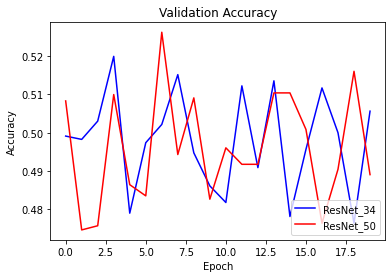

In [27]:
import matplotlib.pyplot as plt
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'r')

# plt.plot(history_plain_34.history['val_accuracy'], 'g')
# plt.plot(history_plain_50.history['val_accuracy'], 'm')

plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(['ResNet_34', 'ResNet_50'], loc='lower right')
plt.show()

## 회고
* 옮겨서 다시 돌리다보니깐 시간이 오버되었습니다... Plain_50 모델을 돌리기까지는 시간이 부족...했습니다.. 제한시간안에 하려고 하니 시각화까지 하려면 12시가 넘을 것 같습니다... 결과는 [Ex-16].fin으로 새로 시각화 부분 추가해서 올리도록 하겠습니다....! 
* 일단 나온 결과상으로 보면 ResNet-34와 ResNet-50 모두 plain model 보다 좋은 성능을 보였습니다.   